In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
#from sklearn.manifold import TSNE
#from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.metrics import confusion_matrix
#import matplotlib.patches as mpatches
#from sklearn.model_selection import train_test_split
#from sklearn.model_selection import StratifiedShuffleSplit
from xgboost.sklearn import XGBClassifier
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
import lightgbm as lgb
import os
import time
#from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import KFold,GroupKFold,StratifiedKFold
import copy
from sklearn.preprocessing import LabelEncoder

from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve ,precision_recall_curve,log_loss,average_precision_score
from sklearn.metrics import f1_score
import random
import gc
pd.options.display.max_columns = 999
pd.options.display.max_rows = 999
%matplotlib inline

In [4]:
#有問題沒用
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [5]:
def show_cor(df1):
    plt.figure(figsize = (20,20))
    df_corr = df1.corr()
    sns.heatmap(df_corr,fmt = '0.2f',annot = True,xticklabels=df_corr.columns,yticklabels=df_corr.columns,cmap="Reds")
    plt.show()

In [6]:
# FREQUENCY ENCODE TOGETHER
def encode_FE(df1, df2, cols):
    for col in cols:
        df = pd.concat([df1[col],df2[col]])
        vc = df.value_counts(dropna=True, normalize=True).to_dict()
        nm = col+'_FE'
        df1[nm] = df1[col].map(vc)
        df1[nm] = df1[nm].astype('float32')
        df2[nm] = df2[col].map(vc)
        df2[nm] = df2[nm].astype('float32')       
        print("'"+nm+"'",', ',end='')

In [7]:
# LABEL ENCODE
def encode_LE(cat_cols,train,test):
    for col in cat_cols:
        if col in train.columns:
            le = LabelEncoder()
            le.fit(list(train[col].astype(str).values) + list(test[col].astype(str).values))
            train[col] = le.transform(list(train[col].astype(str).values))
            test[col] = le.transform(list(test[col].astype(str).values))      

In [8]:
def group_ag(main_columns, uids, train_df, test_df, aggregations=['mean'],
              fillna = True):
    # AGGREGATION OF MAIN WITH UID FOR GIVEN STATISTICS
    for main_column in main_columns:  
        for col in uids:
            for agg_type in aggregations:
                new_col_name = main_column+'__'+col+'_'+agg_type
                #拼接训练集和测试集
                temp_df = pd.concat([train_df[[col, main_column]], test_df[[col,main_column]]])  
                #求AGG
                temp_df = temp_df.groupby([col])[main_column].agg([agg_type]).reset_index().rename(columns={agg_type: new_col_name})
                # 取出目标列作为索引
                temp_df.index = list(temp_df[col])
                # 生成map对应的字典
                temp_df = temp_df[new_col_name].to_dict()   

                train_df[new_col_name] = train_df[col].map(temp_df).astype('float32')
                test_df[new_col_name]  = test_df[col].map(temp_df).astype('float32')
                
                if fillna:
                    train_df[new_col_name].fillna(-100,inplace=True)
                    test_df[new_col_name].fillna(-100,inplace=True)  
                    
                print("'"+new_col_name+"'",', ',end='')
#group_ag(['conam'],['cano'],df,df_test,['mean','std'])
#df['conam_cano_std'].value_counts()

In [9]:
def fillna(df1,df2,col):
    df1[col] = df1[col].map( {'Y': 1, 'N': 0} )
    df2[col] = df2[col].map( {'Y': 1, 'N': 0} )
    df1[col]=df1[col].fillna(-100)
    df2[col]=df2[col].fillna(-100)     
    print(df1[col].value_counts(dropna=False, normalize=True).head())     

In [10]:
def fillNY(df1,df2,col):
    df1[col] = df1[col].map( {'Y': 1, 'N': 0} )
    df2[col] = df2[col].map( {'Y': 1, 'N': 0} )   
    print(df1[col].value_counts(dropna=False, normalize=True).head())      

In [11]:
# COMBINE FEATURES
def encode_CB(col1,col2,df1,df2):
    nm = col1+'_'+col2
    df1[nm] = df1[col1].astype(str)+'_'+df1[col2].astype(str)
    df2[nm] = df2[col1].astype(str)+'_'+df2[col2].astype(str) 
    le = LabelEncoder()
    le.fit(list(df[nm].astype(str).values) + list(df_test[nm].astype(str).values))
    df[nm] = le.transform(list(df[nm].astype(str).values))
    df_test[nm] = le.transform(list(df_test[nm].astype(str).values))
    print(nm,', ',end='')

In [12]:
def money_process(data):
    log =[]
    sqrt =[]
    for i in data['conam']:
        if(i==0):
            sqrt.append(i)
            log.append(i) 
        else:
            l = np.log(i)
            s = np.sqrt(i)
            sqrt.append(s)
            log.append(l)
    #data['conam_log'] = log
    data['conam_sqrt'] = sqrt  
#money_process(df)
#money_process(df_test)
#print(df['conam_log'].head())

In [13]:
def change_time(data):
    time = data['loctm']
    hour = []
    hour_min = []
    minute = []
    second = []
    for i in time:        
        h = int(i/10000)
        h_m=int(i/100)
        m = int(i%10000/100)
        s = int(i%100)
        hour.append(h)
        hour_min.append(h_m)
        minute.append(m)
        second.append(s)
    data['loctm_hour'] = hour
    data['loctm_min'] = minute
    data['loctm_s'] = second
    data['loctm_hour_min'] = hour_min

In [14]:
# PR 曲线对比
def show_pr():
        l_pr,l_re,l_t = precision_recall_curve(y_valid_df,last_pred)
        pr,re,t = precision_recall_curve(y_valid_df,pred)
        plt.figure(figsize=(8,8))
        plt.plot(l_pr,l_re,color='red',label='last best')
        plt.plot(pr,re,color='green',label="now")
        plt.legend()
        plt.show()

In [15]:
#df_sortprob已經做對抗驗證
df_sortprob = pd.read_csv('df_sortprob_23_no_test.csv')
df = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

In [16]:
big_top_value_cols = [col for col in df.columns if df[col].value_counts(dropna=False, normalize=True).values[0] > 0.9]
big_top_value_cols.remove('fraud_ind')
big_top_value_cols.remove('stscd')
#big_top_value_cols.remove('iterm')
#big_top_value_cols.remove('hcefg')
#big_top_value_cols.remove('contp')
big_top_value_cols

['contp', 'flbmk', 'flg_3dsmk', 'hcefg', 'insfg', 'iterm', 'ovrlt']

In [17]:
#not use label encoding
use_label_encoding =False
if use_label_encoding:
    fillna(df,df_test,'flbmk')
    fillna(df,df_test,'flg_3dsmk')
    cat_cols =  list(df.columns)
    cat_cols.remove('fraud_ind')
    cat_cols.remove('flbmk')
    cat_cols.remove('flg_3dsmk')
    cat_cols.remove('txkey')
    cat_cols.remove('loctm')
    cat_cols.remove('locdt')
    cat_cols.remove('conam')
    encode_LE(cat_cols,df,df_test)
    df['flg_3dsmk'].value_counts(dropna=False, normalize=True).head()
else:    
    fillNY(df,df_test,'insfg')
    fillNY(df,df_test,'ovrlt')
    fillNY(df,df_test,'ecfg')
    fillna(df,df_test,'flbmk')
    fillna(df,df_test,'flg_3dsmk')

0    0.972196
1    0.027804
Name: insfg, dtype: float64
0    0.986693
1    0.013307
Name: ovrlt, dtype: float64
0    0.745513
1    0.254487
Name: ecfg, dtype: float64
 0.0      0.988399
-100.0    0.008267
 1.0      0.003334
Name: flbmk, dtype: float64
 0.0      0.949454
 1.0      0.042279
-100.0    0.008267
Name: flg_3dsmk, dtype: float64


In [18]:
change_time(df_sortprob)
change_time(df)
change_time(df_test)

In [21]:
#做備份
df_sortprob=df_sortprob.drop(big_top_value_cols, axis=1)
df=df.drop(big_top_value_cols, axis=1)
df_test=df_test.drop(big_top_value_cols, axis=1)
df_backup = copy.copy(df_sortprob)
df_test_backup = copy.copy(df_test)
print(df.columns)
print(df.shape)

Index(['acqic', 'bacno', 'cano', 'conam', 'csmcu', 'ecfg', 'etymd',
       'fraud_ind', 'locdt', 'loctm', 'mcc', 'mchno', 'scity', 'stocn',
       'stscd', 'txkey', 'loctm_hour', 'loctm_min', 'loctm_s',
       'loctm_hour_min'],
      dtype='object')
(1521787, 20)


## 從這裡開始

In [22]:
seed = 42#default 42
np.random.seed(seed)
random.seed(seed)
params = {'num_leaves': 499,
          'min_child_weight': 0.009009297771374483,
          'feature_fraction': 0.8931730501715401,
          'bagging_fraction': 0.8249551970384116,#subsample
          'min_data_in_leaf': 120,
          'objective': 'binary',
          'max_depth': 47,
          'learning_rate': 0.1,         
          "bagging_seed": 11,
          "metric": 'auc',        
          'reg_alpha': 1.1690935357787136, #lambda_l1 
          'reg_lambda': 1.119698800271026,  #lambda_l2
          'n_jobs':8, #num_threads 
          'device': 'cpu',
          'gpu_platform_id': 1,
          'gpu_device_id': 0,
          'seed': seed,         
          #'cat_smooth '   
          'is_unbalance': True,
          'gpu_use_dp' : True
          #'scale_pos_weight':79.8717361224713
         }


In [23]:
df = copy.copy(df_backup)
df_test = copy.copy(df_test_backup)
print(df.shape[1])
print(df_test.shape[1])
print(df.columns)
print(df_test.columns)

20
19
Index(['acqic', 'bacno', 'cano', 'conam', 'csmcu', 'ecfg', 'etymd',
       'fraud_ind', 'locdt', 'loctm', 'mcc', 'mchno', 'scity', 'stocn',
       'stscd', 'txkey', 'loctm_hour', 'loctm_min', 'loctm_s',
       'loctm_hour_min'],
      dtype='object')
Index(['acqic', 'bacno', 'cano', 'conam', 'csmcu', 'ecfg', 'etymd', 'locdt',
       'loctm', 'mcc', 'mchno', 'scity', 'stocn', 'stscd', 'txkey',
       'loctm_hour', 'loctm_min', 'loctm_s', 'loctm_hour_min'],
      dtype='object')


In [24]:
#新特徵
encode_CB('bacno','cano',df,df_test) 
encode_CB('mcc','mchno',df,df_test)
encode_CB('stocn','scity',df,df_test)
encode_CB('stscd','csmcu',df,df_test)
encode_CB('cano','mcc_mchno',df,df_test)



bacno_cano , mcc_mchno , stocn_scity , stscd_csmcu , cano_mcc_mchno , 

In [25]:
cano_col=['acqic', 'conam', 'csmcu', 'ecfg', 'etymd',
        'locdt', 'loctm', 'mcc', 'mchno', 'scity', 'stocn',
       'stscd',  'loctm_hour', 'loctm_min', 'loctm_s']
for col in cano_col:
    encode_CB('cano',col,df,df_test)

cano_acqic , cano_conam , cano_csmcu , cano_ecfg , cano_etymd , cano_locdt , cano_loctm , cano_mcc , cano_mchno , cano_scity , cano_stocn , cano_stscd , cano_loctm_hour , cano_loctm_min , cano_loctm_s , 

In [26]:
count_features =['cano_locdt']   
encode_FE(df,df_test,count_features)
cf2 = ['cano_locdt_FE']

'cano_locdt_FE' , 

In [27]:
count_features =['acqic', 'bacno', 'cano', 'conam',  'csmcu', 'ecfg', 'etymd',
         'mcc', 'mchno',
       'scity', 'stocn', 'stscd',  'loctm_hour', 'stocn_scity','mcc_mchno']   
encode_FE(df,df_test,count_features)
count_f =  [ 'acqic_FE' , 'bacno_FE' , 'cano_FE'  , 'csmcu_FE'
      , 'scity_FE'   , 
       'loctm_hour_FE' , 'mcc_mchno_FE' , ]

'acqic_FE' , 'bacno_FE' , 'cano_FE' , 'conam_FE' , 'csmcu_FE' , 'ecfg_FE' , 'etymd_FE' , 'mcc_FE' , 'mchno_FE' , 'scity_FE' , 'stocn_FE' , 'stscd_FE' , 'loctm_hour_FE' , 'stocn_scity_FE' , 'mcc_mchno_FE' , 

In [28]:
col1s =['acqic', 'conam',  'csmcu', 'ecfg', 'etymd',
         'mcc', 'mchno',
       'scity', 'stocn', 'stscd',  'loctm_hour', 'stocn_scity','mcc_mchno']
for col in col1s:      
    group_ag([col],['cano'],df,df_test,['mean','std'])  


'acqic__cano_mean' , 'acqic__cano_std' , 'conam__cano_mean' , 'conam__cano_std' , 'csmcu__cano_mean' , 'csmcu__cano_std' , 'ecfg__cano_mean' , 'ecfg__cano_std' , 'etymd__cano_mean' , 'etymd__cano_std' , 'mcc__cano_mean' , 'mcc__cano_std' , 'mchno__cano_mean' , 'mchno__cano_std' , 'scity__cano_mean' , 'scity__cano_std' , 'stocn__cano_mean' , 'stocn__cano_std' , 'stscd__cano_mean' , 'stscd__cano_std' , 'loctm_hour__cano_mean' , 'loctm_hour__cano_std' , 'stocn_scity__cano_mean' , 'stocn_scity__cano_std' , 'mcc_mchno__cano_mean' , 'mcc_mchno__cano_std' , 

In [29]:
gf_cano =['acqic__cano_mean' , 'acqic__cano_std' , 'conam__cano_mean' , 'conam__cano_std' , 'csmcu__cano_mean' , 'csmcu__cano_std' , 'ecfg__cano_mean' , 'ecfg__cano_std' , 'etymd__cano_mean' , 'etymd__cano_std' , 'mcc__cano_mean' , 'mcc__cano_std' , 'mchno__cano_mean' , 'mchno__cano_std' , 'scity__cano_mean' , 'scity__cano_std' , 'stocn__cano_mean' , 'stocn__cano_std' , 'stscd__cano_mean' , 'stscd__cano_std' , 'loctm_hour__cano_mean' , 'loctm_hour__cano_std' , 'stocn_scity__cano_mean' , 'stocn_scity__cano_std' , 'mcc_mchno__cano_mean' , 'mcc_mchno__cano_std' , ]
re_gf =['etymd__cano_std' ,'stscd__cano_std'  ]

gf_cano = set(gf_cano) -set(re_gf)

In [30]:
re_num_2 =['ecfg']
new = set(col1s)-set(re_num_2)
for col in list(new):      
    group_ag([col],['cano_mcc'],df,df_test,['mean','std']) 
for col in list(new):      
    group_ag([col],['cano_locdt'],df,df_test,['mean','std']) 

'mcc_mchno__cano_mcc_mean' , 'mcc_mchno__cano_mcc_std' , 'mcc__cano_mcc_mean' , 'mcc__cano_mcc_std' , 'mchno__cano_mcc_mean' , 'mchno__cano_mcc_std' , 'stscd__cano_mcc_mean' , 'stscd__cano_mcc_std' , 'stocn__cano_mcc_mean' , 'stocn__cano_mcc_std' , 'etymd__cano_mcc_mean' , 'etymd__cano_mcc_std' , 'acqic__cano_mcc_mean' , 'acqic__cano_mcc_std' , 'loctm_hour__cano_mcc_mean' , 'loctm_hour__cano_mcc_std' , 'conam__cano_mcc_mean' , 'conam__cano_mcc_std' , 'scity__cano_mcc_mean' , 'scity__cano_mcc_std' , 'csmcu__cano_mcc_mean' , 'csmcu__cano_mcc_std' , 'stocn_scity__cano_mcc_mean' , 'stocn_scity__cano_mcc_std' , 'mcc_mchno__cano_locdt_mean' , 'mcc_mchno__cano_locdt_std' , 'mcc__cano_locdt_mean' , 'mcc__cano_locdt_std' , 'mchno__cano_locdt_mean' , 'mchno__cano_locdt_std' , 'stscd__cano_locdt_mean' , 'stscd__cano_locdt_std' , 'stocn__cano_locdt_mean' , 'stocn__cano_locdt_std' , 'etymd__cano_locdt_mean' , 'etymd__cano_locdt_std' , 'acqic__cano_locdt_mean' , 'acqic__cano_locdt_std' , 'loctm_hour

In [31]:
for col in list(new):      
    group_ag([col],['cano_scity'],df,df_test,['mean','std'])

'mcc_mchno__cano_scity_mean' , 'mcc_mchno__cano_scity_std' , 'mcc__cano_scity_mean' , 'mcc__cano_scity_std' , 'mchno__cano_scity_mean' , 'mchno__cano_scity_std' , 'stscd__cano_scity_mean' , 'stscd__cano_scity_std' , 'stocn__cano_scity_mean' , 'stocn__cano_scity_std' , 'etymd__cano_scity_mean' , 'etymd__cano_scity_std' , 'acqic__cano_scity_mean' , 'acqic__cano_scity_std' , 'loctm_hour__cano_scity_mean' , 'loctm_hour__cano_scity_std' , 'conam__cano_scity_mean' , 'conam__cano_scity_std' , 'scity__cano_scity_mean' , 'scity__cano_scity_std' , 'csmcu__cano_scity_mean' , 'csmcu__cano_scity_std' , 'stocn_scity__cano_scity_mean' , 'stocn_scity__cano_scity_std' , 

In [32]:
gf_cano_mcc=[ 'loctm_hour__cano_mcc_mean' , 'loctm_hour__cano_mcc_std' , 'stocn__cano_mcc_mean' , 'stocn__cano_mcc_std' , 'stscd__cano_mcc_mean' , 'stscd__cano_mcc_std' , 'scity__cano_mcc_mean' , 'scity__cano_mcc_std' , 'conam__cano_mcc_mean' , 'conam__cano_mcc_std' ,  ]

In [33]:
gf_cano_locdt=['etymd__cano_locdt_mean' , 'etymd__cano_locdt_std' , 'loctm_hour__cano_locdt_mean' , 'loctm_hour__cano_locdt_std' , 'stocn__cano_locdt_mean' , 'stocn__cano_locdt_std' , 'mcc_mchno__cano_locdt_mean' , 'mcc_mchno__cano_locdt_std' , 'mcc__cano_locdt_mean' , 'mcc__cano_locdt_std' , 'acqic__cano_locdt_mean' , 'acqic__cano_locdt_std' , 'csmcu__cano_locdt_mean' , 'csmcu__cano_locdt_std' , 'stocn_scity__cano_locdt_mean' , 'stocn_scity__cano_locdt_std' , 'stscd__cano_locdt_mean' , 'stscd__cano_locdt_std' , 'scity__cano_locdt_mean' , 'scity__cano_locdt_std' , 'conam__cano_locdt_mean' , 'conam__cano_locdt_std' , 'mchno__cano_locdt_mean' , 'mchno__cano_locdt_std' ,  ]

now remove loctm_hour__cano_mcc_mean

train_df.columns =  Index(['acqic', 'acqic_FE', 'acqic__cano_locdt_mean', 'acqic__cano_locdt_std',
       'acqic__cano_mean', 'acqic__cano_std', 'bacno_FE', 'cano_FE',
       'cano_locdt_FE', 'conam', 'conam__cano_locdt_mean',
       'conam__cano_locdt_std', 'conam__cano_mcc_mean', 'conam__cano_mcc_std',
       'conam__cano_mean', 'conam__cano_std', 'csmcu', 'csmcu_FE',
       'csmcu__cano_locdt_mean', 'csmcu__cano_locdt_std', 'csmcu__cano_mean',
       'csmcu__cano_std', 'ecfg', 'ecfg__cano_mean', 'ecfg__cano_std', 'etymd',
       'etymd__cano_locdt_mean', 'etymd__cano_locdt_std', 'etymd__cano_mean',
       'loctm_hour', 'loctm_hour_FE', 'loctm_hour__cano_locdt_mean',
       'loctm_hour__cano_locdt_std', 'loctm_hour__cano_mcc_std',
       'loctm_hour__cano_mean', 'loctm_hour__cano_std', 'mcc',
       'mcc__cano_locdt_mean', 'mcc__cano_locdt_std', 'mcc__cano_mean',
       'mcc__cano_std', 'mcc_mchno', 'mcc_mchno_FE',
       'mcc_mchno__cano_locdt_m

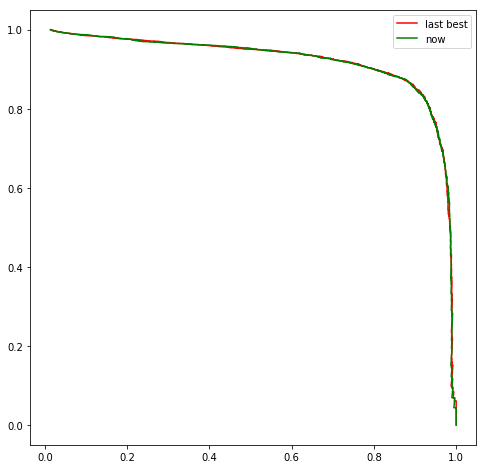

------------------------------------- loctm_hour__cano_mcc_mean count= 1
-------------------------------------------------------------------------
now remove loctm_hour__cano_mcc_std

train_df.columns =  Index(['acqic', 'acqic_FE', 'acqic__cano_locdt_mean', 'acqic__cano_locdt_std',
       'acqic__cano_mean', 'acqic__cano_std', 'bacno_FE', 'cano_FE',
       'cano_locdt_FE', 'conam', 'conam__cano_locdt_mean',
       'conam__cano_locdt_std', 'conam__cano_mcc_mean', 'conam__cano_mcc_std',
       'conam__cano_mean', 'conam__cano_std', 'csmcu', 'csmcu_FE',
       'csmcu__cano_locdt_mean', 'csmcu__cano_locdt_std', 'csmcu__cano_mean',
       'csmcu__cano_std', 'ecfg', 'ecfg__cano_mean', 'ecfg__cano_std', 'etymd',
       'etymd__cano_locdt_mean', 'etymd__cano_locdt_std', 'etymd__cano_mean',
       'loctm_hour', 'loctm_hour_FE', 'loctm_hour__cano_locdt_mean',
       'loctm_hour__cano_locdt_std', 'loctm_hour__cano_mcc_mean',
       'loctm_hour__cano_mean', 'loctm_hour__cano_std', 'mcc',
       'm

[800]	training's auc: 0.999998	valid_1's auc: 0.992526
[900]	training's auc: 0.999998	valid_1's auc: 0.992552
[1000]	training's auc: 0.999998	valid_1's auc: 0.992574
[1100]	training's auc: 0.999998	valid_1's auc: 0.992574
Early stopping, best iteration is:
[967]	training's auc: 0.999998	valid_1's auc: 0.992575
      auc =  0.9925749546401761
last  auc =  0.992790544595652
     f1 =  0.8698122529644269
last f1 =  0.869918699186992
     average_precision =  0.9211060585121417
last average_precision =  0.9211744662152569
-------------------------------------------------------------------------
now remove stscd__cano_mcc_mean

train_df.columns =  Index(['acqic', 'acqic_FE', 'acqic__cano_locdt_mean', 'acqic__cano_locdt_std',
       'acqic__cano_mean', 'acqic__cano_std', 'bacno_FE', 'cano_FE',
       'cano_locdt_FE', 'conam', 'conam__cano_locdt_mean',
       'conam__cano_locdt_std', 'conam__cano_mcc_mean', 'conam__cano_mcc_std',
       'conam__cano_mean', 'conam__cano_std', 'csmcu', 'csmcu_F

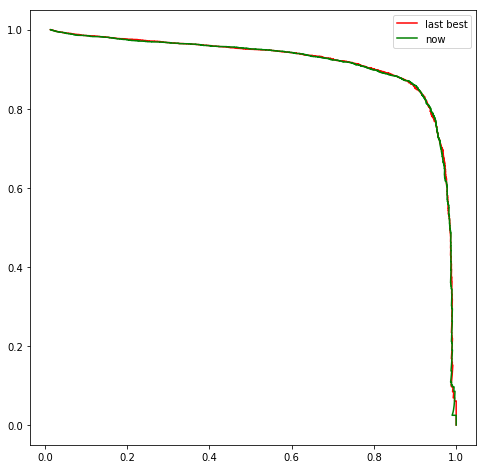

------------------------------------- stscd__cano_mcc_std count= 1
-------------------------------------------------------------------------
now remove scity__cano_mcc_mean

train_df.columns =  Index(['acqic', 'acqic_FE', 'acqic__cano_locdt_mean', 'acqic__cano_locdt_std',
       'acqic__cano_mean', 'acqic__cano_std', 'bacno_FE', 'cano_FE',
       'cano_locdt_FE', 'conam', 'conam__cano_locdt_mean',
       'conam__cano_locdt_std', 'conam__cano_mcc_mean', 'conam__cano_mcc_std',
       'conam__cano_mean', 'conam__cano_std', 'csmcu', 'csmcu_FE',
       'csmcu__cano_locdt_mean', 'csmcu__cano_locdt_std', 'csmcu__cano_mean',
       'csmcu__cano_std', 'ecfg', 'ecfg__cano_mean', 'ecfg__cano_std', 'etymd',
       'etymd__cano_locdt_mean', 'etymd__cano_locdt_std', 'etymd__cano_mean',
       'loctm_hour', 'loctm_hour_FE', 'loctm_hour__cano_locdt_mean',
       'loctm_hour__cano_locdt_std', 'loctm_hour__cano_mcc_mean',
       'loctm_hour__cano_mcc_std', 'loctm_hour__cano_mean',
       'loctm_hour__ca

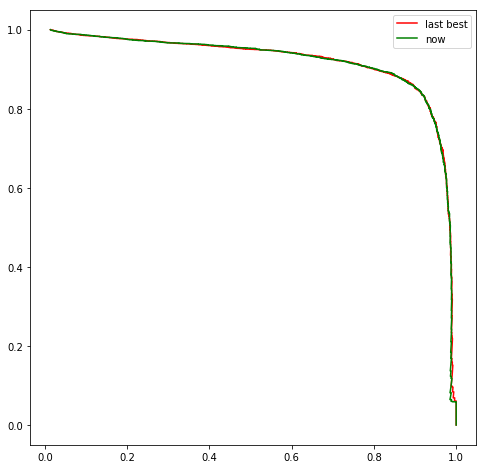

------------------------------------- scity__cano_mcc_std count= 1
-------------------------------------------------------------------------
now remove conam__cano_mcc_mean

train_df.columns =  Index(['acqic', 'acqic_FE', 'acqic__cano_locdt_mean', 'acqic__cano_locdt_std',
       'acqic__cano_mean', 'acqic__cano_std', 'bacno_FE', 'cano_FE',
       'cano_locdt_FE', 'conam', 'conam__cano_locdt_mean',
       'conam__cano_locdt_std', 'conam__cano_mcc_std', 'conam__cano_mean',
       'conam__cano_std', 'csmcu', 'csmcu_FE', 'csmcu__cano_locdt_mean',
       'csmcu__cano_locdt_std', 'csmcu__cano_mean', 'csmcu__cano_std', 'ecfg',
       'ecfg__cano_mean', 'ecfg__cano_std', 'etymd', 'etymd__cano_locdt_mean',
       'etymd__cano_locdt_std', 'etymd__cano_mean', 'loctm_hour',
       'loctm_hour_FE', 'loctm_hour__cano_locdt_mean',
       'loctm_hour__cano_locdt_std', 'loctm_hour__cano_mcc_mean',
       'loctm_hour__cano_mcc_std', 'loctm_hour__cano_mean',
       'loctm_hour__cano_std', 'mcc', 'mcc__ca

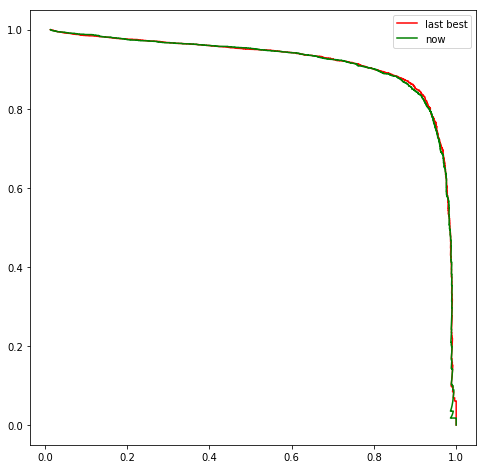

------------------------------------- conam__cano_mcc_mean count= 1
-------------------------------------------------------------------------
now remove conam__cano_mcc_std

train_df.columns =  Index(['acqic', 'acqic_FE', 'acqic__cano_locdt_mean', 'acqic__cano_locdt_std',
       'acqic__cano_mean', 'acqic__cano_std', 'bacno_FE', 'cano_FE',
       'cano_locdt_FE', 'conam', 'conam__cano_locdt_mean',
       'conam__cano_locdt_std', 'conam__cano_mcc_mean', 'conam__cano_mean',
       'conam__cano_std', 'csmcu', 'csmcu_FE', 'csmcu__cano_locdt_mean',
       'csmcu__cano_locdt_std', 'csmcu__cano_mean', 'csmcu__cano_std', 'ecfg',
       'ecfg__cano_mean', 'ecfg__cano_std', 'etymd', 'etymd__cano_locdt_mean',
       'etymd__cano_locdt_std', 'etymd__cano_mean', 'loctm_hour',
       'loctm_hour_FE', 'loctm_hour__cano_locdt_mean',
       'loctm_hour__cano_locdt_std', 'loctm_hour__cano_mcc_mean',
       'loctm_hour__cano_mcc_std', 'loctm_hour__cano_mean',
       'loctm_hour__cano_std', 'mcc', 'mcc__c

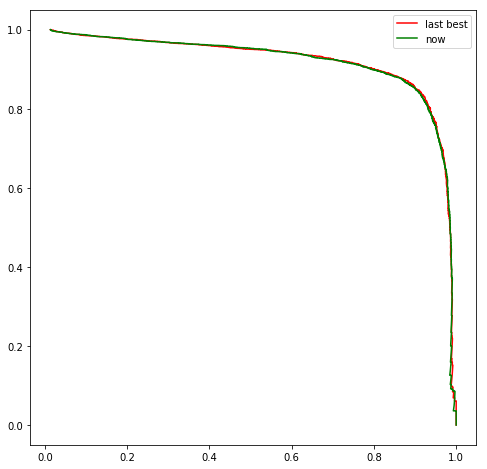

------------------------------------- conam__cano_mcc_std count= 1
-------------------------------------------------------------------------


In [53]:
#DECREASE FEATURE
#col1s =['acqic', 'conam',  'csmcu', 'ecfg', 'etymd',
#         'mcc', 'mchno',
#       'scity', 'stocn', 'stscd',  'loctm_hour', 'stocn_scity','mcc_mchno']

#cols2 =['cano']

for col1 in list(gf_cano_mcc):
#    for col2 in cols2:              
        model1_features =['acqic', 'conam',  'csmcu', 'ecfg', 'etymd',
         'mcc', 'mchno', 'scity', 'stocn',
        'stscd', 'loctm_hour','stocn_scity','mcc_mchno' ]      
        #combine feature
        #model1_features.append(col1+'_'+col2)
        #count feature
        #model1_features.append(col1+'_FE')
        #group feature 
        temp = model1_features+count_f+cf2+list(gf_cano)+list(gf_cano_locdt)+list(gf_cano_mcc)
        model1_features= temp.copy()
        #print('now remove '+col1+'__'+col2)
        #model1_features.remove(col1+'__'+col2+'_mean')
        #if(not(col1=='etymd' or col1=='stscd' or col1 =='loctm_hour')): 
        #model1_features.remove(col1+'__'+col2+'_std')
        print('now remove '+col1)
        model1_features.remove(col1)
        model1_features.sort()        
        X_train = df[model1_features]
        Y_train = df['fraud_ind'] 
        df_validation_2 = df.iloc[int(0.8 * len(df)):, ]
        df_train_2 = df.iloc[:int(0.8 * len(df)), ]
        train_df, y_train_df = df_train_2[model1_features], df_train_2['fraud_ind']
        valid_df, y_valid_df = df_validation_2[model1_features], df_validation_2['fraud_ind']
        print()
        print('train_df.columns = ',train_df.columns)
        print('train_df.shape = ',train_df.shape)
        trn_data = lgb.Dataset(train_df, label=y_train_df)
        val_data = lgb.Dataset(valid_df, label=y_valid_df)  
        clf = lgb.train(params,
                    trn_data,
                    num_boost_round= 1000000,
                    valid_sets = [trn_data, val_data],                
                    verbose_eval=100,
                    early_stopping_rounds = 200)   
        pred = clf.predict(valid_df)   
        now_auc = roc_auc_score(y_valid_df, pred)
        print( "      auc = ", now_auc ) 
        pred_file_path = 'compare.csv'
        last_pred = np.array(pd.read_csv(pred_file_path))
        last_auc = roc_auc_score(y_valid_df, last_pred)
        print( "last  auc = ", last_auc ) 
    
        threshold = 0.5
        y_pre = [int(item>threshold) for  item in pred]  
        last_y_pre = [int(item>threshold) for  item in last_pred] 
        now_f1= f1_score(y_valid_df, y_pre)
        last_f1 =f1_score(y_valid_df, last_y_pre)
        print( "     f1 = ", now_f1)
        print( "last f1 = ", last_f1)
        now_ap = average_precision_score(y_valid_df, pred);
        print( "     average_precision = ",now_ap)
        last_ap =average_precision_score(y_valid_df, last_pred)
        print( "last average_precision = ",last_ap)
        count=0
        if(now_ap>=last_ap):
            count=count+1
            print('ap improve')            
        if(now_f1>=last_f1):
            count=count+1
            print('f1 improve')          
        if(now_auc>=last_auc):      
            count=count+1
            print('auc improve')            
        if(count>0 or now_ap>=last_ap):
            show_pr()
            #print('-------------------------------------',col1+'_'+col2,'count=',count)
            #print('-------------------------------------',col1+'_FE','count=',count)
            #print('-------------------------------------',col1+'_'+col2,'count=',count)  
            print('-------------------------------------',col1,'count=',count)  
        print('-------------------------------------------------------------------------')     
        del clf ,trn_data,val_data
        gc.collect()
        gc.collect()
        #print( "  confusion_matrix = \r\n", confusion_matrix(y_valid_df, y_pre) )


train_df.columns =  Index(['acqic', 'acqic_FE', 'acqic__cano_locdt_mean', 'acqic__cano_locdt_std',
       'acqic__cano_mean', 'acqic__cano_std', 'bacno_FE', 'cano_FE',
       'cano_locdt_FE', 'conam', 'conam__cano_locdt_mean',
       'conam__cano_locdt_std', 'conam__cano_mcc_mean', 'conam__cano_mcc_std',
       'conam__cano_mean', 'conam__cano_std', 'csmcu', 'csmcu_FE',
       'csmcu__cano_locdt_mean', 'csmcu__cano_locdt_std', 'csmcu__cano_mean',
       'csmcu__cano_std', 'ecfg', 'ecfg__cano_mean', 'ecfg__cano_std', 'etymd',
       'etymd__cano_acqic_mean', 'etymd__cano_acqic_std',
       'etymd__cano_locdt_mean', 'etymd__cano_locdt_std', 'etymd__cano_mean',
       'loctm_hour', 'loctm_hour_FE', 'loctm_hour__cano_locdt_mean',
       'loctm_hour__cano_locdt_std', 'loctm_hour__cano_mcc_mean',
       'loctm_hour__cano_mcc_std', 'loctm_hour__cano_mean',
       'loctm_hour__cano_std', 'mcc', 'mcc__cano_locdt_mean',
       'mcc__cano_locdt_std', 'mcc__cano_mean', 'mcc__cano_std', 'mcc_mchno

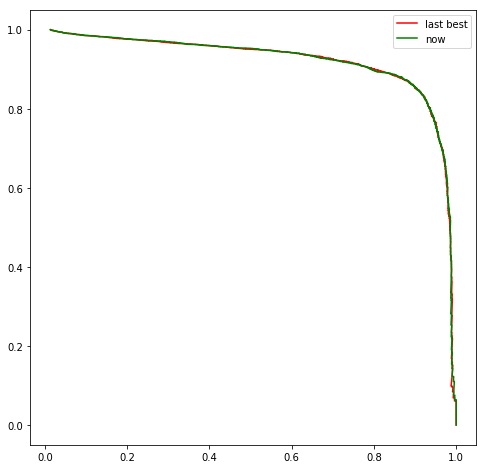

------------------------------------- etymd_cano_acqic count= 2
-------------------------------------------------------------------------

train_df.columns =  Index(['acqic', 'acqic_FE', 'acqic__cano_locdt_mean', 'acqic__cano_locdt_std',
       'acqic__cano_mean', 'acqic__cano_std', 'bacno_FE', 'cano_FE',
       'cano_locdt_FE', 'conam', 'conam__cano_locdt_mean',
       'conam__cano_locdt_std', 'conam__cano_mcc_mean', 'conam__cano_mcc_std',
       'conam__cano_mean', 'conam__cano_std', 'csmcu', 'csmcu_FE',
       'csmcu__cano_locdt_mean', 'csmcu__cano_locdt_std', 'csmcu__cano_mean',
       'csmcu__cano_std', 'ecfg', 'ecfg__cano_mean', 'ecfg__cano_std', 'etymd',
       'etymd__cano_locdt_mean', 'etymd__cano_locdt_std', 'etymd__cano_mean',
       'loctm_hour', 'loctm_hour_FE', 'loctm_hour__cano_acqic_mean',
       'loctm_hour__cano_acqic_std', 'loctm_hour__cano_locdt_mean',
       'loctm_hour__cano_locdt_std', 'loctm_hour__cano_mcc_mean',
       'loctm_hour__cano_mcc_std', 'loctm_hour__c

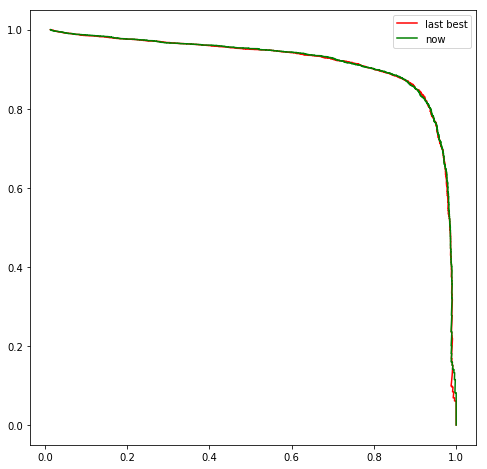

------------------------------------- stocn_cano_acqic count= 2
-------------------------------------------------------------------------

train_df.columns =  Index(['acqic', 'acqic_FE', 'acqic__cano_locdt_mean', 'acqic__cano_locdt_std',
       'acqic__cano_mean', 'acqic__cano_std', 'bacno_FE', 'cano_FE',
       'cano_locdt_FE', 'conam', 'conam__cano_locdt_mean',
       'conam__cano_locdt_std', 'conam__cano_mcc_mean', 'conam__cano_mcc_std',
       'conam__cano_mean', 'conam__cano_std', 'csmcu', 'csmcu_FE',
       'csmcu__cano_locdt_mean', 'csmcu__cano_locdt_std', 'csmcu__cano_mean',
       'csmcu__cano_std', 'ecfg', 'ecfg__cano_mean', 'ecfg__cano_std', 'etymd',
       'etymd__cano_locdt_mean', 'etymd__cano_locdt_std', 'etymd__cano_mean',
       'loctm_hour', 'loctm_hour_FE', 'loctm_hour__cano_locdt_mean',
       'loctm_hour__cano_locdt_std', 'loctm_hour__cano_mcc_mean',
       'loctm_hour__cano_mcc_std', 'loctm_hour__cano_mean',
       'loctm_hour__cano_std', 'mcc', 'mcc__cano_locdt_me

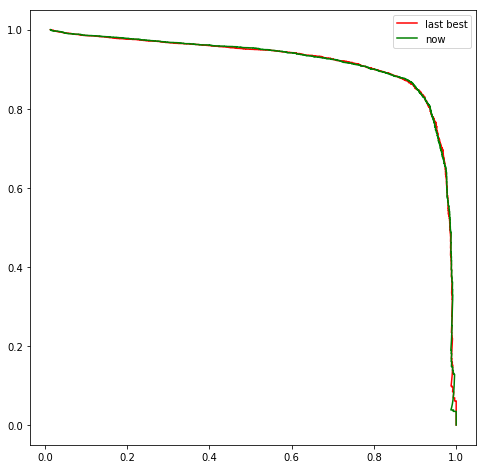

------------------------------------- mcc_cano_acqic count= 1
-------------------------------------------------------------------------

train_df.columns =  Index(['acqic', 'acqic_FE', 'acqic__cano_acqic_mean', 'acqic__cano_acqic_std',
       'acqic__cano_locdt_mean', 'acqic__cano_locdt_std', 'acqic__cano_mean',
       'acqic__cano_std', 'bacno_FE', 'cano_FE', 'cano_locdt_FE', 'conam',
       'conam__cano_locdt_mean', 'conam__cano_locdt_std',
       'conam__cano_mcc_mean', 'conam__cano_mcc_std', 'conam__cano_mean',
       'conam__cano_std', 'csmcu', 'csmcu_FE', 'csmcu__cano_locdt_mean',
       'csmcu__cano_locdt_std', 'csmcu__cano_mean', 'csmcu__cano_std', 'ecfg',
       'ecfg__cano_mean', 'ecfg__cano_std', 'etymd', 'etymd__cano_locdt_mean',
       'etymd__cano_locdt_std', 'etymd__cano_mean', 'loctm_hour',
       'loctm_hour_FE', 'loctm_hour__cano_locdt_mean',
       'loctm_hour__cano_locdt_std', 'loctm_hour__cano_mcc_mean',
       'loctm_hour__cano_mcc_std', 'loctm_hour__cano_mean',
 

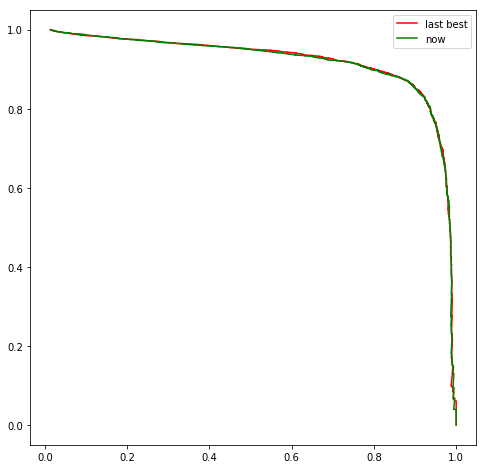

------------------------------------- stocn_scity_cano_acqic count= 1
-------------------------------------------------------------------------

train_df.columns =  Index(['acqic', 'acqic_FE', 'acqic__cano_locdt_mean', 'acqic__cano_locdt_std',
       'acqic__cano_mean', 'acqic__cano_std', 'bacno_FE', 'cano_FE',
       'cano_locdt_FE', 'conam', 'conam__cano_locdt_mean',
       'conam__cano_locdt_std', 'conam__cano_mcc_mean', 'conam__cano_mcc_std',
       'conam__cano_mean', 'conam__cano_std', 'csmcu', 'csmcu_FE',
       'csmcu__cano_locdt_mean', 'csmcu__cano_locdt_std', 'csmcu__cano_mean',
       'csmcu__cano_std', 'ecfg', 'ecfg__cano_mean', 'ecfg__cano_std', 'etymd',
       'etymd__cano_locdt_mean', 'etymd__cano_locdt_std', 'etymd__cano_mean',
       'loctm_hour', 'loctm_hour_FE', 'loctm_hour__cano_locdt_mean',
       'loctm_hour__cano_locdt_std', 'loctm_hour__cano_mcc_mean',
       'loctm_hour__cano_mcc_std', 'loctm_hour__cano_mean',
       'loctm_hour__cano_std', 'mcc', 'mcc__cano_lo

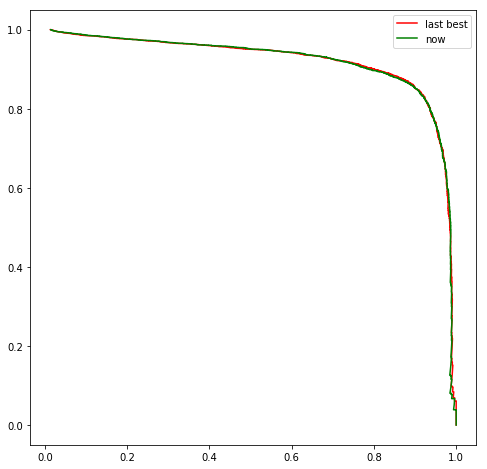

------------------------------------- stscd_cano_acqic count= 1
-------------------------------------------------------------------------

train_df.columns =  Index(['acqic', 'acqic_FE', 'acqic__cano_locdt_mean', 'acqic__cano_locdt_std',
       'acqic__cano_mean', 'acqic__cano_std', 'bacno_FE', 'cano_FE',
       'cano_locdt_FE', 'conam', 'conam__cano_locdt_mean',
       'conam__cano_locdt_std', 'conam__cano_mcc_mean', 'conam__cano_mcc_std',
       'conam__cano_mean', 'conam__cano_std', 'csmcu', 'csmcu_FE',
       'csmcu__cano_locdt_mean', 'csmcu__cano_locdt_std', 'csmcu__cano_mean',
       'csmcu__cano_std', 'ecfg', 'ecfg__cano_mean', 'ecfg__cano_std', 'etymd',
       'etymd__cano_locdt_mean', 'etymd__cano_locdt_std', 'etymd__cano_mean',
       'loctm_hour', 'loctm_hour_FE', 'loctm_hour__cano_locdt_mean',
       'loctm_hour__cano_locdt_std', 'loctm_hour__cano_mcc_mean',
       'loctm_hour__cano_mcc_std', 'loctm_hour__cano_mean',
       'loctm_hour__cano_std', 'mcc', 'mcc__cano_locdt_me

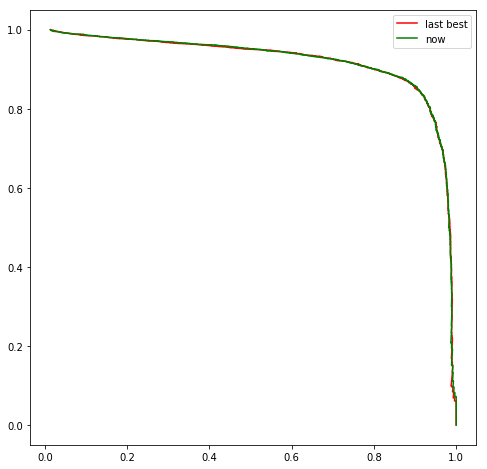

------------------------------------- scity_cano_acqic count= 2
-------------------------------------------------------------------------

train_df.columns =  Index(['acqic', 'acqic_FE', 'acqic__cano_locdt_mean', 'acqic__cano_locdt_std',
       'acqic__cano_mean', 'acqic__cano_std', 'bacno_FE', 'cano_FE',
       'cano_locdt_FE', 'conam', 'conam__cano_acqic_mean',
       'conam__cano_acqic_std', 'conam__cano_locdt_mean',
       'conam__cano_locdt_std', 'conam__cano_mcc_mean', 'conam__cano_mcc_std',
       'conam__cano_mean', 'conam__cano_std', 'csmcu', 'csmcu_FE',
       'csmcu__cano_locdt_mean', 'csmcu__cano_locdt_std', 'csmcu__cano_mean',
       'csmcu__cano_std', 'ecfg', 'ecfg__cano_mean', 'ecfg__cano_std', 'etymd',
       'etymd__cano_locdt_mean', 'etymd__cano_locdt_std', 'etymd__cano_mean',
       'loctm_hour', 'loctm_hour_FE', 'loctm_hour__cano_locdt_mean',
       'loctm_hour__cano_locdt_std', 'loctm_hour__cano_mcc_mean',
       'loctm_hour__cano_mcc_std', 'loctm_hour__cano_mean',

In [599]:
#ADD FEATURE
col1s =['acqic', 'conam',  'csmcu', 'ecfg', 'etymd',
         'mcc', 'mchno',
       'scity', 'stocn', 'stscd',  'loctm_hour', 'stocn_scity','mcc_mchno']  
cols2 =['cano_acqic']
for col1 in new:
    for col2 in cols2:              
        model1_features =['acqic', 'conam',  'csmcu', 'ecfg', 'etymd',
         'mcc', 'mchno', 'scity', 'stocn',
        'stscd', 'loctm_hour','stocn_scity','mcc_mchno' ]      
        #combine feature
        #model1_features.append(col1+'_'+col2)
        #count feature
        #model1_features.append(col1+'_FE')
        #group feature 
        temp = model1_features+count_f+cf2+list(gf_cano)+list(gf_cano_locdt)+list(gf_cano_mcc)
        model1_features = list(temp)
        model1_features.append(col1+'__'+col2+'_mean')
        model1_features.append(col1+'__'+col2+'_std')
        model1_features.sort()
          
        X_train = df[model1_features]
        Y_train = df['fraud_ind'] 
        df_validation_2 = df.iloc[int(0.8 * len(df)):, ]
        df_train_2 = df.iloc[:int(0.8 * len(df)), ]
        train_df, y_train_df = df_train_2[model1_features], df_train_2['fraud_ind']
        valid_df, y_valid_df = df_validation_2[model1_features], df_validation_2['fraud_ind']
        print()
        print('train_df.columns = ',train_df.columns)
        print('train_df.shape = ',train_df.shape)
        trn_data = lgb.Dataset(train_df, label=y_train_df)
        val_data = lgb.Dataset(valid_df, label=y_valid_df)  
        clf = lgb.train(params,
                    trn_data,
                    num_boost_round= 100000,
                    valid_sets = [trn_data, val_data],                
                    verbose_eval=100,
                    early_stopping_rounds = 200)   
        pred = clf.predict(valid_df)   
        now_auc = roc_auc_score(y_valid_df, pred)
        #print( "      auc = ", now_auc ) 
        pred_file_path = 'compare.csv'
        last_pred = np.array(pd.read_csv(pred_file_path))
        last_auc = roc_auc_score(y_valid_df, last_pred)
        #print( "last  auc = ", last_auc ) 
    
        threshold = 0.5
        y_pre = [int(item>threshold) for  item in pred]  
        last_y_pre = [int(item>threshold) for  item in last_pred] 
        now_f1= f1_score(y_valid_df, y_pre)
        last_f1 =f1_score(y_valid_df, last_y_pre)
        #print( "     f1 = ", now_f1)
        #print( "last f1 = ", last_f1)
        now_ap = average_precision_score(y_valid_df, pred);
        #print( "     average_precision = ",now_ap)
        last_ap =average_precision_score(y_valid_df, last_pred)
        #print( "last average_precision = ",last_ap)
        count=0
        if(now_ap>last_ap):
            count=count+1
            print('ap improve')            
        if(now_f1>last_f1):
            count=count+1
            print('f1 improve')          
        if(now_auc>last_auc):      
            count=count+1
            print('auc improve')            
        if(count>0 or now_ap>last_ap):
            show_pr()
            #print('-------------------------------------',col1+'_'+col2,'count=',count)
            #print('-------------------------------------',col1+'_FE','count=',count)
            print('-------------------------------------',col1+'_'+col2,'count=',count)  
        print('-------------------------------------------------------------------------')     
        del clf ,trn_data,val_data
        gc.collect()
        gc.collect()
        #print( "  confusion_matrix = \r\n", confusion_matrix(y_valid_df, y_pre) )

In [34]:
model1_features =['acqic', 'conam',  'csmcu', 'ecfg', 'etymd',
       'mcc', 'mchno', 'scity', 'stocn',
       'stscd', 'loctm_hour','stocn_scity','mcc_mchno' ]
#remove_f = ['contp','iterm','hcefg']
temp = model1_features+count_f+cf2+list(gf_cano_locdt)+list(gf_cano_mcc)+list(gf_cano)
model1_features= list(temp.copy())
model1_features.sort()
X_train = df[model1_features]
Y_train = df['fraud_ind']
X_test = df_test[model1_features]
#print(model1_features)
print(X_train.shape[1])
print(X_train.columns)
#show_cor(df[model1_features])

79
Index(['acqic', 'acqic_FE', 'acqic__cano_locdt_mean', 'acqic__cano_locdt_std',
       'acqic__cano_mean', 'acqic__cano_std', 'bacno_FE', 'cano_FE',
       'cano_locdt_FE', 'conam', 'conam__cano_locdt_mean',
       'conam__cano_locdt_std', 'conam__cano_mcc_mean', 'conam__cano_mcc_std',
       'conam__cano_mean', 'conam__cano_std', 'csmcu', 'csmcu_FE',
       'csmcu__cano_locdt_mean', 'csmcu__cano_locdt_std', 'csmcu__cano_mean',
       'csmcu__cano_std', 'ecfg', 'ecfg__cano_mean', 'ecfg__cano_std', 'etymd',
       'etymd__cano_locdt_mean', 'etymd__cano_locdt_std', 'etymd__cano_mean',
       'loctm_hour', 'loctm_hour_FE', 'loctm_hour__cano_locdt_mean',
       'loctm_hour__cano_locdt_std', 'loctm_hour__cano_mcc_mean',
       'loctm_hour__cano_mcc_std', 'loctm_hour__cano_mean',
       'loctm_hour__cano_std', 'mcc', 'mcc__cano_locdt_mean',
       'mcc__cano_locdt_std', 'mcc__cano_mean', 'mcc__cano_std', 'mcc_mchno',
       'mcc_mchno_FE', 'mcc_mchno__cano_locdt_mean',
       'mcc_mchno__c

In [35]:
# 将概率最大的20%作为验证集
df_validation_2 = df.iloc[int(0.8 * len(df)):, ]
df_train_2 = df.iloc[:int(0.8 * len(df)), ]

In [36]:
predictions = np.zeros(len(X_test))

train_df.columns =  Index(['acqic', 'acqic_FE', 'acqic__cano_locdt_mean', 'acqic__cano_locdt_std',
       'acqic__cano_mean', 'acqic__cano_std', 'bacno_FE', 'cano_FE',
       'cano_locdt_FE', 'conam', 'conam__cano_locdt_mean',
       'conam__cano_locdt_std', 'conam__cano_mcc_mean', 'conam__cano_mcc_std',
       'conam__cano_mean', 'conam__cano_std', 'csmcu', 'csmcu_FE',
       'csmcu__cano_locdt_mean', 'csmcu__cano_locdt_std', 'csmcu__cano_mean',
       'csmcu__cano_std', 'ecfg', 'ecfg__cano_mean', 'ecfg__cano_std', 'etymd',
       'etymd__cano_locdt_mean', 'etymd__cano_locdt_std', 'etymd__cano_mean',
       'loctm_hour', 'loctm_hour_FE', 'loctm_hour__cano_locdt_mean',
       'loctm_hour__cano_locdt_std', 'loctm_hour__cano_mcc_mean',
       'loctm_hour__cano_mcc_std', 'loctm_hour__cano_mean',
       'loctm_hour__cano_std', 'mcc', 'mcc__cano_locdt_mean',
       'mcc__cano_locdt_std', 'mcc__cano_mean', 'mcc__cano_std', 'mcc_mchno',
       'mcc_mchno_FE', 'mcc_mchno__cano_locdt_mean',
   

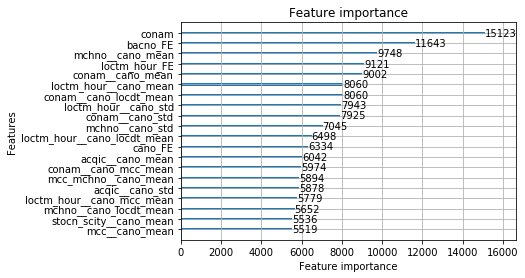

In [37]:
    tStart = time.time()#計時開始
    train_df, y_train_df = df_train_2[model1_features], df_train_2['fraud_ind']
    valid_df, y_valid_df = df_validation_2[model1_features], df_validation_2['fraud_ind']
    print('train_df.columns = ',train_df.columns)
    print('train_df.shape = ',train_df.shape)
    trn_data = lgb.Dataset(train_df, label=y_train_df)
    val_data = lgb.Dataset(valid_df, label=y_valid_df)  
    clf = lgb.train(params,
                    trn_data,
                    num_boost_round= 200000,
                    valid_sets = [trn_data, val_data],                
                    verbose_eval=100,
                    early_stopping_rounds = 200)   
    pred = clf.predict(valid_df)   
    
    
    pred_file_path = 'compare.csv'
    last_pred = np.array(pd.read_csv(pred_file_path))   
    
    threshold = 0.5
    y_pre = [int(item>threshold) for  item in pred]  
    last_y_pre = [int(item>threshold) for  item in last_pred] 
    print( "      auc = ", roc_auc_score(y_valid_df, pred) ) 
    print( "last  auc = ", roc_auc_score(y_valid_df, last_pred) ) 
    print( "     f1 = ", f1_score(y_valid_df, y_pre))
    print( "last f1 = ", f1_score(y_valid_df, last_y_pre))     
    print( "     average_precision = ",average_precision_score(y_valid_df, pred))
    print( "last average_precision = ",average_precision_score(y_valid_df, last_pred))

    print( "  confusion_matrix = \r\n", confusion_matrix(y_valid_df, y_pre) )

    lgb.plot_importance(booster=clf,max_num_features = 20,ignore_zero =False)
    print('_'*100)
    tEnd = time.time()#計時結束
    #列印結果
    print ("It cost %f sec" % (tEnd - tStart))#會自動做近位  

last  auc =  0.49541787650349745


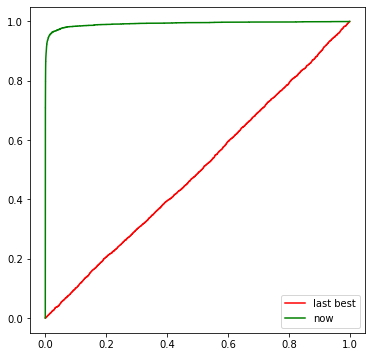

In [38]:
pred_file_path = 'compare.csv'
last_pred = np.array(pd.read_csv(pred_file_path))
print( "last  auc = ", roc_auc_score(y_valid_df, last_pred) )  
# ROC 曲线对比
l_fpr,l_tpr,l_t = roc_curve(y_valid_df,last_pred)
fpr,tpr,t = roc_curve(y_valid_df,pred)
plt.figure(figsize=(6,6))
plt.plot(l_fpr,l_tpr,color='red',label='last best')
plt.plot(fpr,tpr,color='green',label="now")
plt.legend()  

C:\Users\user\Anaconda3\lib\site-packages\IPython\core\events.py:88: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
C:\Users\user\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


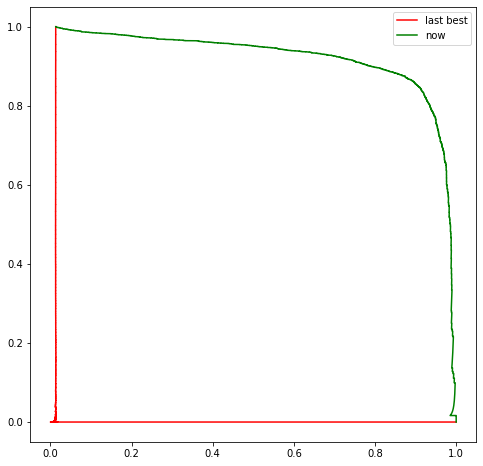

In [39]:
# PR 曲线对比
l_pr,l_re,l_t = precision_recall_curve(y_valid_df,last_pred)
pr,re,t = precision_recall_curve(y_valid_df,pred)
plt.figure(figsize=(8,8))
plt.plot(l_pr,l_re,color='red',label='last best')
plt.plot(pr,re,color='green',label="now")
plt.legend() 

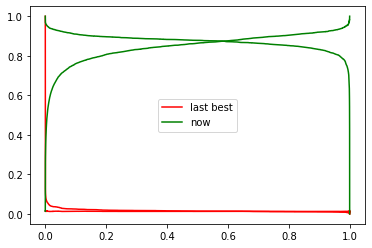

In [40]:
plt.plot(l_t,l_pr[:-1],color='red',label='last best')
plt.plot(l_t,l_re[:-1],color='red')
plt.legend() 
plt.plot(t,pr[:-1],color='green',label="now")
plt.plot(t,re[:-1],color='green')
plt.legend() 

## 是否将存为新指标

In [41]:
'''是否将存为新指标'''
print("save  file...")
last_pred = pd.DataFrame({'pred':pred})
last_pred.to_csv('compare.csv',index=None)

save  file...


## train start!

(1521787, 79)
train feature  Index(['acqic', 'acqic_FE', 'acqic__cano_locdt_mean', 'acqic__cano_locdt_std',
       'acqic__cano_mean', 'acqic__cano_std', 'bacno_FE', 'cano_FE',
       'cano_locdt_FE', 'conam', 'conam__cano_locdt_mean',
       'conam__cano_locdt_std', 'conam__cano_mcc_mean', 'conam__cano_mcc_std',
       'conam__cano_mean', 'conam__cano_std', 'csmcu', 'csmcu_FE',
       'csmcu__cano_locdt_mean', 'csmcu__cano_locdt_std', 'csmcu__cano_mean',
       'csmcu__cano_std', 'ecfg', 'ecfg__cano_mean', 'ecfg__cano_std', 'etymd',
       'etymd__cano_locdt_mean', 'etymd__cano_locdt_std', 'etymd__cano_mean',
       'loctm_hour', 'loctm_hour_FE', 'loctm_hour__cano_locdt_mean',
       'loctm_hour__cano_locdt_std', 'loctm_hour__cano_mcc_mean',
       'loctm_hour__cano_mcc_std', 'loctm_hour__cano_mean',
       'loctm_hour__cano_std', 'mcc', 'mcc__cano_locdt_mean',
       'mcc__cano_locdt_std', 'mcc__cano_mean', 'mcc__cano_std', 'mcc_mchno',
       'mcc_mchno_FE', 'mcc_mchno__cano_locdt_m

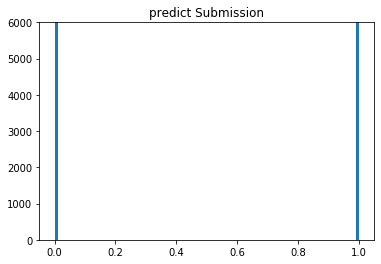

____________________________________________________________________________________________________
Fold 1
  confusion_matrix = 
 [[498896   1452]
 [  1916   4914]]


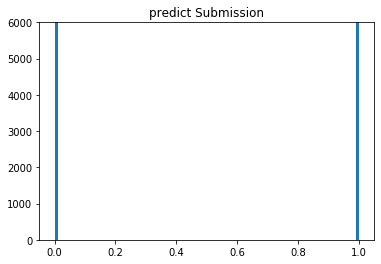

____________________________________________________________________________________________________
Fold 2
  confusion_matrix = 
 [[499139   1674]
 [  1741   4720]]


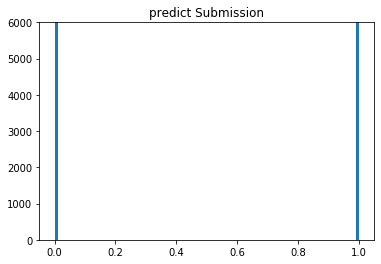

avg  auc =  0.9863255907779869
avg  f1 =  0.7386447923384672
last oof  auc =  0.9717715815967198
oof  auc =  0.986159532855773
last oof  f1 =  0.37163878782951565
oof  f1 =  0.7386703124208821
last oof  average_precision =  0.645282268301403
oof  average_precision =  0.7939652517734155
confusion_matrix =
[[1496877    4555]
 [   5767   14588]]


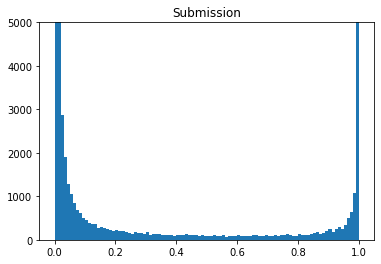

auc improve
f1 improve
ap improve
It cost 459.113469 sec


In [53]:
    tStart = time.time()#計時開始   
    feature_importances = pd.DataFrame()
    feature_importances['feature'] = X_train.columns
    splits = 3
    oof = np.zeros(len(X_train))
    folds = KFold(n_splits = splits)
    folds = GroupKFold(n_splits=splits)
    ##folds = StratifiedKFold(n_splits=splits, shuffle=True, random_state=SEED)
    split_groups = df['locdt'] #group
    #split_groups = df['fraud_ind'] #startifiedkfold   
    f1_avg = 0
    auc_avg = 0
    predictions = np.zeros(len(X_test))
    print(X_train.shape)
    print('train feature ',X_train.columns)
    #for fold_, (trn_idx, val_idx) in enumerate(folds.split(X_train, Y_train)): #kfold
    for fold_, (trn_idx, val_idx) in enumerate(folds.split(X_train, Y_train,groups=split_groups)): #groupkfold and startifiedfold
        print('_'*100)
    
        print("Fold {}".format(fold_))
        
        train_df, y_train_df = X_train.iloc[trn_idx], Y_train.iloc[trn_idx]
        valid_df, y_valid_df = X_train.iloc[val_idx], Y_train.iloc[val_idx]
        
        
        trn_data = lgb.Dataset(train_df, label=y_train_df)
        val_data = lgb.Dataset(valid_df, label=y_valid_df)
    
        clf = lgb.train(params,
                    trn_data,
                    num_boost_round= 100000,
                    valid_sets = [trn_data, val_data],
                    # categorical_feature=cat_cols,
                    verbose_eval=0,
                    early_stopping_rounds =200 )
        pred = clf.predict(valid_df)
        oof[val_idx] = pred
        #print(pred[0])
        feature_importances['fold_{}'.format(fold_ + 1)] = clf.feature_importance()
    
        #print( "  auc = ", roc_auc_score(y_valid_df, pred) )    
        threshold = 0.5
        y_pre = [int(item>threshold) for  item in pred]   
        #print( "  f1 = ", f1_score(y_valid_df, y_pre))
        print( "  confusion_matrix = \r\n", confusion_matrix(y_valid_df, y_pre) )
        auc_avg+= roc_auc_score(y_valid_df, pred)
        f1_avg+=f1_score(y_valid_df, y_pre)
        
        predictions += clf.predict(X_test) / splits
        del trn_data, val_data
        gc.collect()
   
        prediction = [int(item>threshold) for  item in predictions]    
 
        plt.hist(y_pre,bins=100)
        plt.ylim((0,6000))
        plt.title('predict Submission')
        plt.show()
    pred_file_path = 'compare_fold.csv'
    last_oof = np.array(pd.read_csv(pred_file_path))  
    print( "avg  auc = ", auc_avg/ splits )
    print( "avg  f1 = ", f1_avg/ splits)
    print( "last oof  auc = ", roc_auc_score(Y_train, last_oof) )
    print( "oof  auc = ", roc_auc_score(Y_train, oof) )  
    last_oof_threshold = [int(item>0.5) for  item in last_oof] 
    oof_threshold = [int(item>0.5) for  item in oof]
    print( "last oof  f1 = ", f1_score(Y_train, last_oof_threshold))
    print( "oof  f1 = ", f1_score(Y_train, oof_threshold))
    print( "last oof  average_precision = ",average_precision_score(Y_train,last_oof))
    print( "oof  average_precision = ",average_precision_score(Y_train,oof))
    print( "confusion_matrix =")
    print(confusion_matrix(Y_train, oof_threshold))
   
    plt.hist(oof,bins=100)
    plt.ylim((0,5000))
    plt.title('Submission')
    plt.show()  
    tEnd = time.time()#計時結束
    #列印結果
    if(roc_auc_score(Y_train, last_oof)<roc_auc_score(Y_train, oof)):
        print("auc improve")
    if(f1_score(Y_train, last_oof_threshold)<f1_score(Y_train, oof_threshold)):
        print("f1 improve")
    if(average_precision_score(Y_train,last_oof)<average_precision_score(Y_train,oof)):
        print('ap improve')
    print ("It cost %f sec" % (tEnd - tStart))#會自動做近位
    

C:\Users\user\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


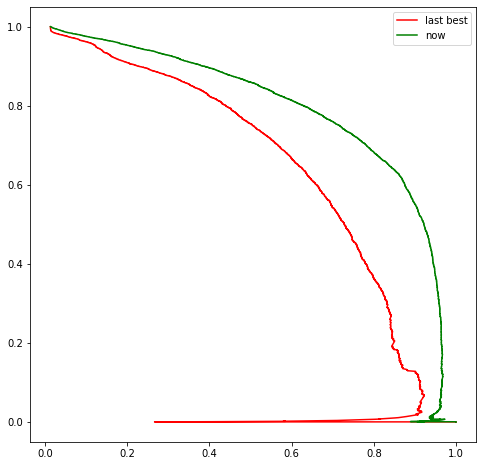

In [54]:
# PR 曲线对比
l_pr,l_re,l_t = precision_recall_curve(Y_train,last_oof)
pr,re,t = precision_recall_curve(Y_train,oof)
plt.figure(figsize=(8,8))
plt.plot(l_pr,l_re,color='red',label='last best')
plt.plot(pr,re,color='green',label="now")
plt.legend() 
plt.show()

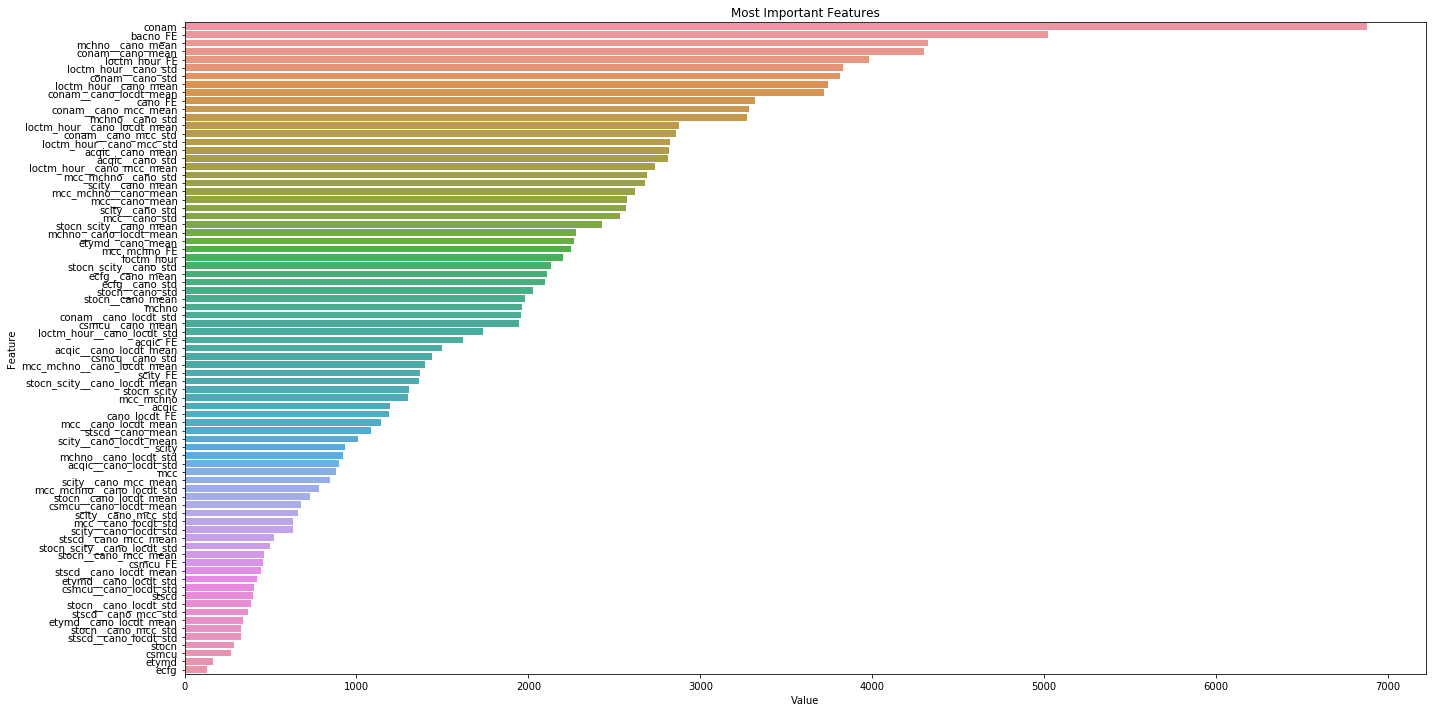

In [55]:
feature_imp = pd.DataFrame(sorted(zip(clf.feature_importance(),model1_features)), columns=['Value','Feature'])
plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False).iloc[:100])
plt.title('Most Important Features')
plt.tight_layout()
plt.show()

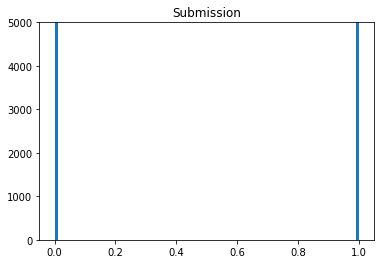

testdata = 421665
1.34% of testdata = 5650.0
fraud predict = 6886


In [56]:
# 结果保存
plt.hist(prediction,bins=100)
plt.ylim((0,5000))
plt.title('Submission')
plt.show()
sampleSubmission = pd.read_csv('submission_test_sample.csv')
sampleSubmission['fraud_ind'] = prediction
sampleSubmission.to_csv('submission_test.csv',index = None)
print('testdata =',df_test['txkey'].count())
print('1.34% of testdata =',round(df_test['txkey'].count()*0.0134))
print('fraud predict =',sampleSubmission['fraud_ind'].value_counts()[1])


In [57]:
'''是否将存为新指标'''
print("save  file...")
last_pred = pd.DataFrame({'pred':oof})
last_pred.to_csv('compare_fold.csv',index=None)

save  file...


In [ ]:
seed_num=[42,1121,10,934151515,29595,4462,520,777,1562323,999,915]
for i in seed_num:
    params['seed']= i
    print(params['seed'])
    ####################################
    #######################################################
    # PR 曲线对比
    l_pr,l_re,l_t = precision_recall_curve(Y_train,last_oof)
    pr,re,t = precision_recall_curve(Y_train,oof)
    plt.figure(figsize=(8,8))
    plt.plot(l_pr,l_re,color='red',label='last best')
    plt.plot(pr,re,color='green',label="now")
    plt.legend() 
    plt.show()    
    # 结果保存
    plt.hist(predictions,bins=100)
    plt.ylim((0,5000))
    plt.title('Submission')
    plt.show()
    sampleSubmission = pd.read_csv('submission_test_sample.csv')
    sampleSubmission['fraud_ind'] = prediction 
    sampleSubmission.to_csv('submission_test66941_seed'+str(seed)+'.csv',index = None)
    print('done here')